<center><span style="background-color: rgb(251, 160, 38); font-size: 32px;">  <b>NUCLIO DIGITAL SCHOOL -</b> MASTER EN DATA SCIENCE  </span></center>
    
<br>
    
<center><a href = https://nuclio.school/wp-content/uploads/2019/10/nucleoDS-newBlack.png > <img src="https://nuclio.school/wp-content/uploads/2019/10/nucleoDS-newBlack.png" width=400 height=100><a/></center>

#  <font color='orange'>  Ejemplo sktime <font>




Este ejemplo muestra cómo se podrían modelizar datos "más reales" utilizando sktime. Los datos se accceden a través  del siguiente [enlance](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=20f4a87ebb65b510VgnVCM1000001d4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default) del Ayuntamiento de Madrid correspondiente a accidentes de tráfico con implicación de bicicletas. La muestra corresponde a las incidencias durante 2023 hasta el mes de Octubre (incluido). Los resultados pueden mejorarse pero el propósito del notebook es ilustrar cómo sería un workflow completo utilizando sktime así como los posibles transformadores que se pueden aplicar para corregir irregularidades en la serie temporal. 



In [228]:
import pandas as pd
import numpy as np
import plotly.express as px
import skimpy as sk
from datetime import datetime

from matplotlib.pylab import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = 15, 8
plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

In [229]:
bicis = pd.read_csv('data/AccidentesBicicletas_2023.csv', sep=';')
bicis.head(3)

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,positiva_droga
0,2023S000057,02/01/2023,7:50:00,CALL. GOYA / CALL. LOMBIA,86,4,SALAMANCA,Colisión fronto-lateral,Nublado,Bicicleta,Conductor,De 55 a 59 años,Hombre,NaN,NaN,442943680,4475109106,N,NaN
1,2023S000123,03/01/2023,13:20:00,"AVDA. ENTREVIAS, 100",100,13,PUENTE DE VALLECAS,Colisión fronto-lateral,Despejado,Bicicleta EPAC (pedaleo asistido),Conductor,De 55 a 59 años,Hombre,1.0,Atención en urgencias sin posterior ingreso,443717786,4469886737,N,NaN
2,2023S000136,03/01/2023,15:45:00,PASEO. CASTELLANA / MIGUEL AN,51,7,CHAMBERÍ,Colisión fronto-lateral,Despejado,Bicicleta,Conductor,De 45 a 49 años,Hombre,3.0,Ingreso superior a 24 horas,441406026,4476550072,N,NaN


In [230]:
bicis['fecha'] = pd.to_datetime(bicis['fecha'], format='%d/%m/%Y')


## Análisis descriptivo

In [231]:
sk.skim(bicis)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 737    │ │ string      │ 13    │                                                          │
│ │ Number of columns │ 19     │ │ int64       │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_n ┃     ┃       ┃          ┃         ┃          ┃          ┃          ┃          ┃         ┃        ┃  │
│ ┃ ame      ┃ NA  ┃ NA %  ┃ mean     ┃ sd      ┃ p0       ┃ p25      ┃ p50      ┃ p75      ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ cod_dist │   0 │     0 │      8.8 │     5.8 │        1 │        4 │        9 │       13 │      21 │ ▇▃▅▅▂▃ │  │
│ │ rito     │     │       │          │         │          │          │          │          │         │        │  │
│ │ cod_lesi │ 120 │ 16.28 │      5.6 │     3.9 │        1 │        2 │        6 │        7 │      14 │ ▇▁▇  ▂ │  │
│ │ vidad    │     │       │          │         │          │          │          │          │         │        │  │
│ │ coordena │   0 │     0 │ 44000000 │ 3400000 │ 43000000 │ 44000000 │ 44000000 │ 44000000 │ 4500000 │ ▁▅▇▃▂  │  │
│ │ da_x_utm │     │       │        0 │         │        0 │        0 │        0 │        0 │      00 │        │  │
│ │ coordena │   0 │     0 │ 45000000 │ 3600000 │ 45000000 │ 45000000 │ 45000000 │ 45000000 │ 4500000 │  ▁▆▇▂  │  │
│ │ da_y_utm │     │       │       00 │         │       00 │       00 │       00 │       00 │     000 │        │  │
│ │ positiva │ 733 │ 99.46 │        1 │       0 │        1 │        1 │        1 │        1 │       1 │     ▇  │  │
│ │ _droga   │     │       │          │         │          │          │          │          │         │        │  │
│ └──────────┴─────┴───────┴──────────┴─────────┴──────────┴──────────┴──────────┴──────────┴─────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ fecha                  │      0 │         0 │     2023-01-02      │     2023-10-31      │ None             │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA      ┃ NA %

In [232]:
# Fija fecha como índice

bicis['fecha'] = pd.to_datetime(bicis['fecha'], format = '%d/%m/%Y')
bicis = bicis.set_index('fecha')


In [234]:
# Conteos total accidentes

accidentes = pd.DataFrame(bicis.groupby('fecha').size())
accidentes.columns = ['total_accidentes']

px.line(accidentes['total_accidentes'])

In [237]:
accidentes.head(20)

,total_accidentes
fecha,
2023-01-02,1
2023-01-03,3
2023-01-04,3
2023-01-05,1
2023-01-06,2
2023-01-08,3
2023-01-09,4
2023-01-10,1
2023-01-12,1


Hay días que no tienen accidentes y que no aparecen en la muestra inicial (por ejemplo el 7, 11 ó el 17 de Enero). Se pueden transformar los datos para tener un rango de fechas completo en el que los días sin accidentes tengan accidente 0.

In [239]:
# Create a data frame with the dates of 2023

dates_2023 = pd.DataFrame(pd.date_range(start='2023-01-01', end='2023-10-31', freq='D'))
dates_2023.columns = ['fecha']  
dates_2023['fecha'] = pd.to_datetime(dates_2023['fecha'], format = '%Y-%m-%d')
dates_2023 = dates_2023.set_index('fecha')


# Merge the data frames

accidentes_2023 = pd.merge(dates_2023, accidentes, how='left', left_index=True, right_index=True)
accidentes_2023.head(20)






,total_accidentes
fecha,
2023-01-01,NaN
2023-01-02,1.0
2023-01-03,3.0
2023-01-04,3.0
2023-01-05,1.0
2023-01-06,2.0
2023-01-07,NaN
2023-01-08,3.0
2023-01-09,4.0


In [240]:
px.line(accidentes_2023['total_accidentes'])

In [241]:

accidentes_2023['total_accidentes_clean'] = accidentes_2023['total_accidentes'].fillna(0)
accidentes_2023

# En este caso, el poner 0 en los días sin accidentes es una decisión de negocio. En otros casos, podría ser más conveniente aplicar otra estrategia, como por ejemplo, la media de los días anteriores y posteriores o algún tipo de interpolación.

,total_accidentes,total_accidentes_clean
fecha,,
2023-01-01,NaN,0.0
2023-01-02,1.0,1.0
2023-01-03,3.0,3.0
2023-01-04,3.0,3.0
2023-01-05,1.0,1.0
...,...,...
2023-10-27,3.0,3.0
2023-10-28,3.0,3.0
2023-10-29,NaN,0.0


In [242]:
px.line(accidentes_2023['total_accidentes_clean'])

In [243]:
sk.skim(accidentes_2023)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 304    │ │ float64     │ 2     │                                                          │
│ │ Number of columns │ 2      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name                 ┃ NA   ┃ NA %   ┃ mean   ┃ sd    ┃ p0  ┃ p25   ┃ p50  ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ total_accidentes            │   30 │   9.87 │    2.7 │   1.6 │   1 │     1 │    2 │    4 │     9 │  ▇▃▂▁   │  │
│ │ total_accidentes_clean      │    0 │      0 │    2.4 │   1.8 │   0 │     1 │    2 │    3 │     9 │  ▇▆▇▁▁  │  │
│ └─────────────────────────────┴──────┴────────┴────────┴───────┴─────┴───────┴──────┴──────┴───────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [244]:
# Filter rows with missing 

accidentes_2023[accidentes_2023['total_accidentes_clean'].isnull()]

,total_accidentes,total_accidentes_clean
fecha,,


Hacemos un análisis descriptivo para entender las características temporales de nuestros datos

- ¿Qué día son los que presentan más accidentes?

- ¿Cuál es la distribución de accidentes por mes?

- ¿Hay valores atípicos?

Estas cuestiones nos ayudan a informar los argumentos que hay que poner en los transformadores

In [245]:
accidentes_2023['dia_semana'] = accidentes_2023.index.day_name()



days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
accidentes_2023['dia_semana'] = pd.Categorical(accidentes_2023['dia_semana'], categories=days_order, ordered=True)


# Group by 'dia_semana' and sum the 'total_accidentes_clean' column, then sort the result by 'dia_semana'
grouped_data = accidentes_2023.groupby('dia_semana')['total_accidentes_clean'].sum().sort_index()

# Create a bar chart using Plotly Express
px.bar(x=grouped_data.index, y=grouped_data.values, labels={'x': 'dia_semana', 'y': 'total_accidentes_clean'})




- Distintas distribuciones por mes 

- Presencia de atípicos sobretodo en Mayo

In [247]:
accidentes_2023['mes'] = accidentes_2023.index.month_name()

mes_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November','December']
accidentes_2023['mes'] = pd.Categorical(accidentes_2023['mes'], categories=mes_order, ordered=True)

# Plot

grouped_data = accidentes_2023.groupby('mes')['total_accidentes_clean'].sum().sort_index()

grouped_data


px.box(accidentes_2023, x='mes', y='total_accidentes_clean', labels={'mes': 'Mes', 'total_accidentes_clean': 'Total Accidentes'})


## Preprocesamiento. ¿Cómo son los datos?

In [275]:
from statsmodels.tsa.seasonal import seasonal_decompose


from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error

import xgboost as xgb

from xgboost import XGBRegressor 


from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (
    TransformedTargetForecaster)
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, SingleWindowSplitter, ExpandingWindowSplitter, ForecastingGridSearchCV 
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [254]:

accidentes_2023

,total_accidentes_clean,dia_semana,mes
fecha,,,
2023-01-01,0.0,Sunday,January
2023-01-02,1.0,Monday,January
2023-01-03,3.0,Tuesday,January
2023-01-04,3.0,Wednesday,January
2023-01-05,1.0,Thursday,January
...,...,...,...
2023-10-27,3.0,Friday,October
2023-10-28,3.0,Saturday,October
2023-10-29,0.0,Sunday,October


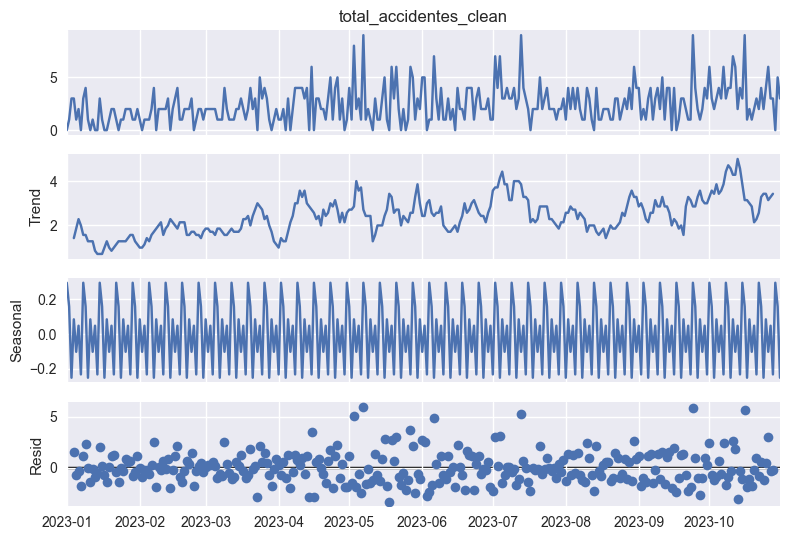

In [256]:
result_decompose_add = seasonal_decompose(accidentes_2023['total_accidentes_clean'].dropna(), model='additive').plot()
# el modelo mutiplicativo no funciona bien porque hay días con 0 accidentes

In [257]:
accidentes_2023 = accidentes_2023.asfreq('D') # set the frequency of the time series to daily
accidentes_2023.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2023-01-01 to 2023-10-31
Freq: D
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   total_accidentes_clean  304 non-null    float64 
 1   dia_semana              304 non-null    category
 2   mes                     304 non-null    category
dtypes: category(2), float64(1)
memory usage: 6.1 KB


## Análisis de estacionariedad y heterocedasticidad

- Aunque el test Dickey Fuller nos indica que los accidentes presentan estacionariedad el test de Mann Kendall confirma que existe una estacionariedad estructural que tiene que ser corregida

- No hay un patrón de estacionalidad claro. No obstante, a raíz de la información arrojada por los gráficos de ADF y PACF pueden intuirse ciertos patrones estacionales que conviene tratar.

- El test de heterocedasticidad nos confirma que nuestra serie es heterocedástica. 

In [258]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

In [259]:
result = adfuller(accidentes_2023['total_accidentes_clean'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Reject the null hypothesis. Time series is stationary.")
else:
    print("Fail to reject the null hypothesis. Time series is non-stationary.")

ADF Statistic: -5.482994653363647
p-value: 2.2623164515280784e-06
Critical Values: {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}
Reject the null hypothesis. Time series is stationary.


In [260]:
import pymannkendall as mk
from statsmodels.stats.diagnostic import het_white

def check_trend(time_series, alpha=0.05):
    """
    Perform the Mann-Kendall test for stationarity on a time series.
    
    H0: No monotonic trend --> Stationary
    Ha : Monotonic trend is present --> Non-Stationary (i.e.  trend exists)
    
    Assumptions
    
    - No correlation
    - No seasonality



    Parameters:
    - time_series: pandas Series or DataFrame column containing the time series data.
    - alpha: Significance level for the test.

    Returns:
    - result: pymannkendall test result object.
    """
    result = mk.original_test(time_series, alpha=alpha)
    return result

In [261]:
check_trend(accidentes_2023['total_accidentes_clean'].dropna(), alpha=0.05)

Mann_Kendall_Test(trend='increasing', h=True, p=8.462456846380917e-08, z=5.356979819117961, Tau=0.20192808754559666, s=9300.0, var_s=3013231.3333333335, slope=0.004273504273504274, intercept=1.3525641025641026)

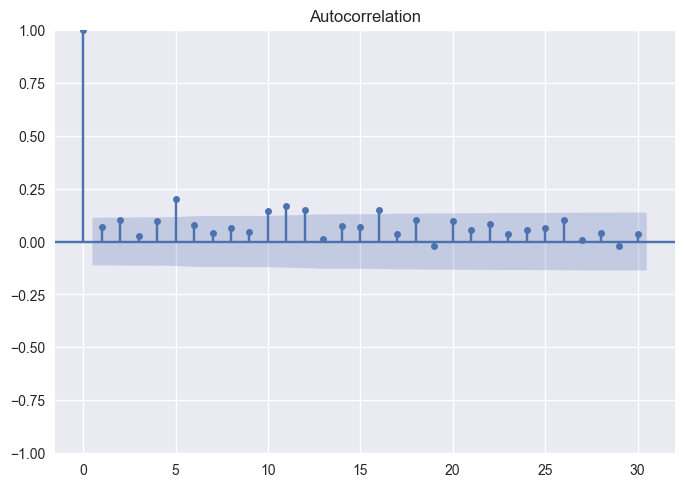

In [262]:
# Estacionalidad

acf = plot_acf(accidentes_2023['total_accidentes_clean'].dropna(), lags=30)

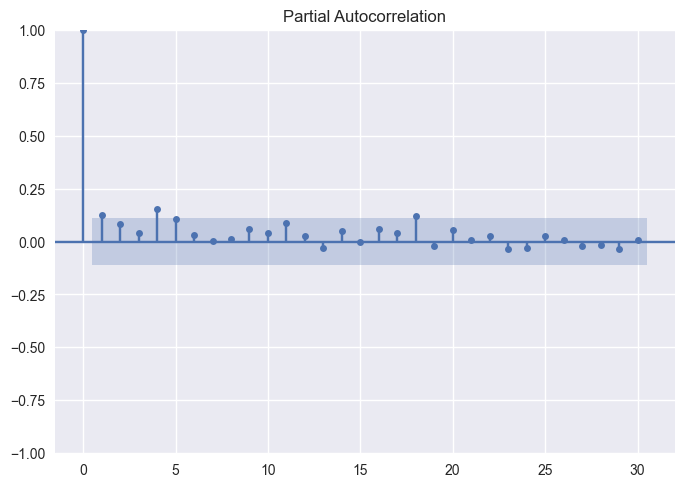

In [151]:
pacf = plot_pacf(accidentes_2023['total_accidentes_clean'].dropna(), lags=30)

- Parece que podría haber una estacionalidad semanal (cada 5 días), pero no es muy clara. Aplicamos transformador para corregirla

In [265]:
# Source: 

from collections import namedtuple
import statsmodels.api as sm

def _check_convert_y(y):
    assert not np.any(np.isnan(y)), "`y` should not have any nan values"
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y = y.values.squeeze()
    assert y.ndim==1
    return y



def check_heteroscedastisticity(y, confidence=0.05):
    y = _check_convert_y(y)
    res = namedtuple("White_Test", ["heteroscedastic", "lm_statistic", "lm_p_value"])
    #Fitting a linear trend regression
    x = np.arange(len(y))
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    lm_stat, lm_p_value, f_stat, f_p_value = het_white(results.resid, x)
    if lm_p_value<confidence and f_p_value < confidence:
        hetero = True
    else:
        hetero = False
    return res(hetero, lm_stat, lm_p_value)

In [266]:
### Check for heterocecdasticity
check_heteroscedastisticity(accidentes_2023['total_accidentes_clean'].dropna(), confidence = 0.05) 

White_Test(heteroscedastic=True, lm_statistic=6.5518036660936385, lm_p_value=0.03778278010058865)

# Modelos

- Comenzamos con especificaciones simmples sin transformación de los datos. Vamos a considerar 3 tipos de modelos que incluyen 

    - Naive
    - KNN
    - XGBoost

## División de las muestras de entrenamiento y evaluación

In [267]:
# Split the data into train and test sets

y_train, y_test = temporal_train_test_split(accidentes_2023['total_accidentes_clean'], test_size=60)  
display(y_train.shape, y_train.head(2), y_train.tail(2))
display(y_test.shape, y_test.head(2), y_test.tail(2))

(244,)

fecha
2023-01-01    0.0
2023-01-02    1.0
Freq: D, Name: total_accidentes_clean, dtype: float64

fecha
2023-08-31    4.0
2023-09-01    4.0
Freq: D, Name: total_accidentes_clean, dtype: float64

(60,)

fecha
2023-09-02    1.0
2023-09-03    2.0
Freq: D, Name: total_accidentes_clean, dtype: float64

fecha
2023-10-30    5.0
2023-10-31    3.0
Freq: D, Name: total_accidentes_clean, dtype: float64

## Definición del horizonte de pronóstico

- Consideramos la muestra de evaluación  

- Empezamos con pronósticos dentro de la muestra

In [268]:
# Forecasting horizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh


ForecastingHorizon(['2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07', '2023-09-08', '2023-09-09',
               '2023-09-10', '2023-09-11', '2023-09-12', '2023-09-13',
               '2023-09-14', '2023-09-15', '2023-09-16', '2023-09-17',
               '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25',
               '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29',
               '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-03',
               '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07',
               '2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11',
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23',
               '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27',
 

## Ajuste de las predicciones

### Naive

In [269]:
forecaster = NaiveForecaster(strategy="last") # last, mean, drift --> estrategias de naive forecaster. Last es similar a recursive en 'xgboost'
forecaster.fit(y_train)
y_pred_naive = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total_accidentes_clean'>)

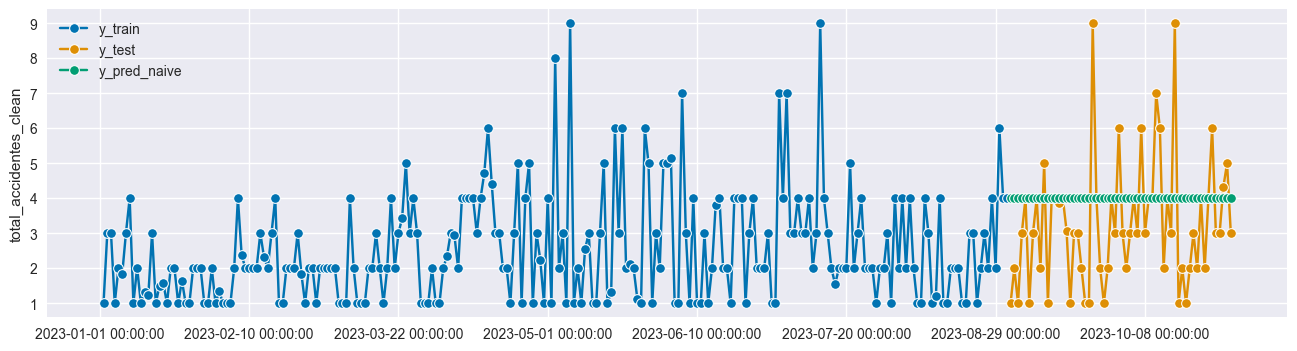

In [160]:
plot_series(y_train, y_test, y_pred_naive, labels=["y_train", "y_test", "y_pred_naive"])

- Sale una línea porque el modelo está considerando únicamente el último valor de la serie temporal para hacer la predicción.

- No es muy informativo, hay que modificar la muestra de datos que queremos que considere el modelo para predecir. 

- Vamos introducir una periodicidad estacional (sp) de 5 (según lo que hemos visto en el gráfico PACF) 

In [270]:
forecaster = NaiveForecaster(strategy="last", sp=5)
forecaster.fit(y_train)
y_pred_naive_imp = forecaster.predict(fh)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total_accidentes_clean'>)

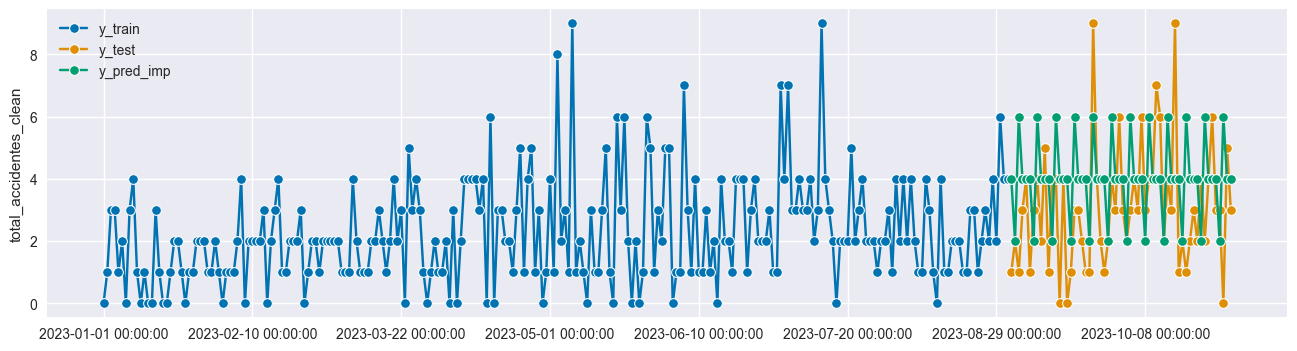

In [271]:
plot_series(y_train, y_test, y_pred_naive_imp, labels=["y_train", "y_test", "y_pred_imp"])

### XGBoost

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total_accidentes_clean'>)

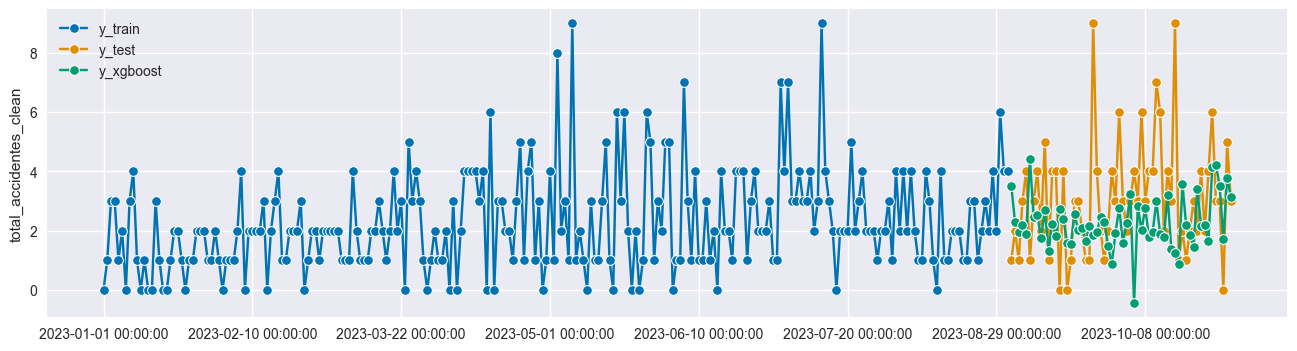

In [272]:
from xgboost import XGBRegressor 


xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive") # recursive, direct, mulitoutput
forecaster_xgb.fit(y_train)
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])

### KNN 

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total_accidentes_clean'>)

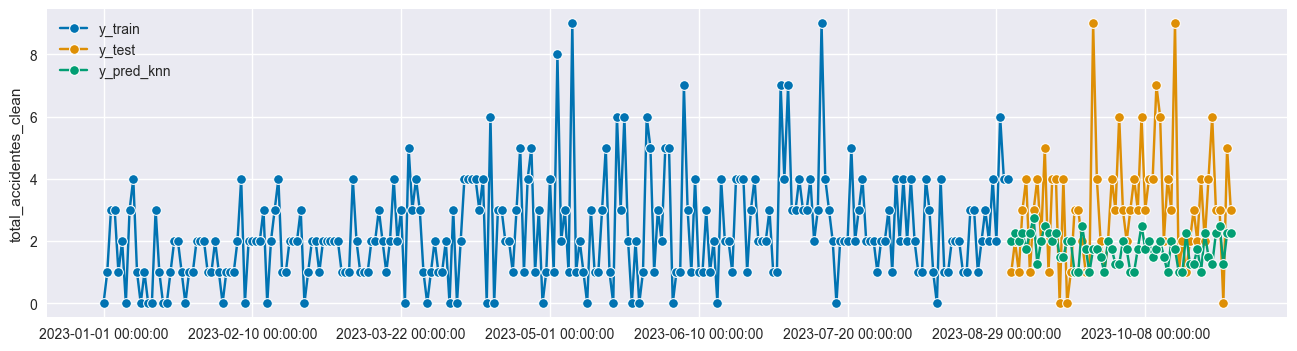

In [273]:
regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, strategy="recursive", window_length=7)
forecaster.fit(y_train.dropna(), fh=fh)
y_pred_knn = forecaster.predict()
plot_series(y_train, y_test, y_pred_knn, labels=["y_train", "y_test", "y_pred_knn"])

## Evaluación de los modelos

In [276]:
mae_naive = mean_absolute_error(y_test, y_pred_naive)
mae_naive_imp = mean_absolute_error(y_test, y_pred_naive_imp)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

# create data frame with mape values

maes = [mae_naive, mae_naive_imp,  mae_xgboost, mae_knn]
models = ['Naive', 'Naive Improved', 'XGBoost', 'KNN']

pd.DataFrame({'Model': models, 'MAE': maes}).sort_values(by='MAE', ascending=True)


,Model,MAE
2,XGBoost,1.636568
0,Naive,1.683333
3,KNN,1.787500
1,Naive Improved,1.850000


# Añadimos transformadores

- Idea: Incorporar el pre procesamiento de los datos como parte del `forecaster`




In [289]:
# Pipeline ---------------

# Define the forecasting horizon
from sktime.transformations.series.boxcox import BoxCoxTransformer


fh = ForecastingHorizon(y_test.index, is_relative=False)
validation_size = len(y_test) # necesaria para hacer la validiación cruzada
cv = SingleWindowSplitter(window_length=len(accidentes_2023)-validation_size,  # training window length
                          fh=validation_size) # forecasting horizon



# Ajusta el regresor y los transformadores que necesitemos
# Source: https://www.sktime.net/en/stable/api_reference/transformations.html
regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize_week", Deseasonalizer(model="additive", sp=5)),         # desestacionaliza cada 5 días
        ("deseasonalize_month", Deseasonalizer(model="additive", sp=30)),        # desestacionaliza cada 30 días
        ('LogTransformer', BoxCoxTransformer(method= 'guerrero', sp=5)),         # corrige heterocedasticidad. aplicamos sp si utlizamos guerrero si no, no hace falta y utiliza mle como método por defecto para estimar lambda
        ('HampelFilter', HampelFilter(window_length=30)),                       # suaviza outliers
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=3))), # elimina tendencia
        ("forecast", make_reduction(regressor, window_length=30, scitype='tabular-regressor')), # ajusta el modelo considerando los últimos 30 días 
        
    ]
)


model= make_reduction(regressor, window_length=30,  scitype='tabular-regressor')



param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20,30],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100,200,300, 500, 1000]
}
gscv = ForecastingRandomizedSearchCV(model, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42,error_score='raise',n_jobs=-1)

gscv.fit(y_train)
y_pred_cv_xgb = gscv.predict(fh)

### Predicciones en la muestra de evaluación

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total_accidentes_clean'>)

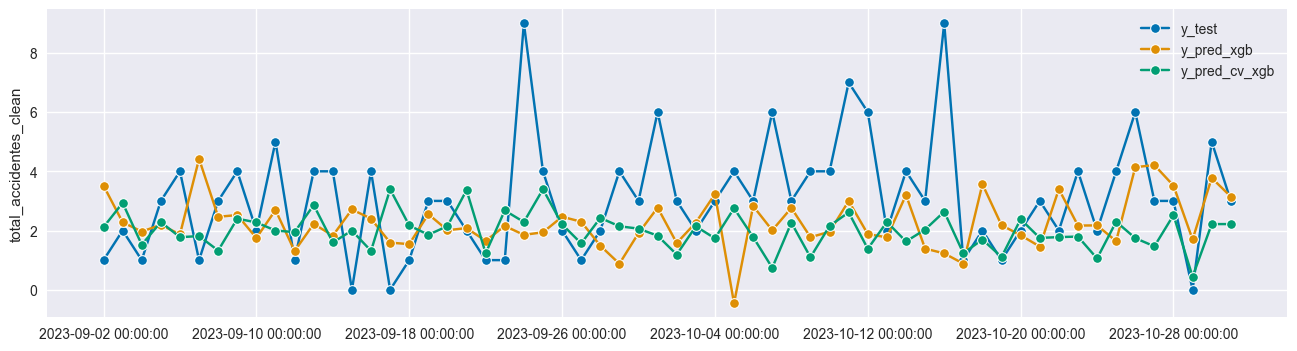

In [290]:
plot_series(y_test, y_pred_xgboost, y_pred_cv_xgb, labels=["y_test", "y_pred_xgb", "y_pred_cv_xgb"])

In [292]:
mae_xgboost_cv = mean_absolute_error(y_test, y_pred_cv_xgb)


maes = [mae_naive, mae_naive_imp,  mae_xgboost, mae_knn, mae_xgboost_cv]
models = ['Naive', 'Naive Improved', 'XGBoost', 'KNN', 'XGBoost CV']

pd.DataFrame({'Model': models, 'MAE': maes}).sort_values(by='MAE', ascending=True)

,Model,MAE
2,XGBoost,1.636568
4,XGBoost CV,1.673498
0,Naive,1.683333
3,KNN,1.787500
1,Naive Improved,1.850000


- Para hacer muestras fuera de la muestra _out sample_ habría que alterar el horizonte de pronóstico

- Posiblemente, para mejorar las previsiones habría que revisar el preprocesamiento y utilizar más información para dotar de más información al modelo. 

